In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K

Using TensorFlow backend.


In [2]:
(X_train,Y_train),(X_test,Y_test) = keras.datasets.reuters.load_data()

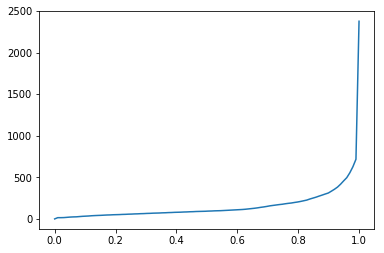

In [3]:
data_input_len_quantile_x = np.linspace(0, 1, num=100)
data_input_len_quantile_y = np.quantile(
    [len(x) for x in X_train] + [len(x) for x in X_test], data_input_len_quantile_x)
plt.plot(data_input_len_quantile_x, data_input_len_quantile_y)
plt.show()

In [4]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=64, padding='post', truncating='post')
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=64, padding='post', truncating='post')
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((8982, 64), (8982,), (2246, 64), (2246,))

In [5]:
data_input_dim = max(np.max(X_train), np.max(X_test)) + 1
data_input_dim

30979

In [6]:
data_output_dim = max(np.max(Y_train), np.max(Y_test)) + 1
data_output_dim

46

In [7]:
class FastWeightsCell(keras.layers.Layer):
    
    def __init__(self,
                 units,
                 fast_learning_rate=0.5,
                 fast_decay_rate=0.95,
                 fast_weights_steps=2,
                 **kwargs):
        self.units = units
        self.fast_learning_rate = fast_learning_rate
        self.fast_decay_rate = fast_decay_rate
        self.fast_weights_steps = fast_weights_steps
        self.state_size = units, units, units**2
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        self.kernel_hidden = self.add_weight(
            shape=(self.units+input_shape[-1], self.units),
            initializer='glorot_normal', name='kernel_hidden')
        self.kernel_output = self.add_weight(
            shape=(self.units, self.units),
            initializer='glorot_normal', name='kernel_output')
        self.bias_output = self.add_weight(
            shape=(self.units,),
            initializer='zeros', name='bias_output')
        super().build(input_shape)
    
    def call(self, inputs, states):
        
        def layer_norm(x):
            norm = K.sqrt(K.sum(K.square(x),axis=-1))
            norm = K.switch(
                K.not_equal(norm,K.zeros_like(norm)),
                norm, K.ones_like(norm))
            return x / K.expand_dims(norm)
        
        _, hidden, fast_weights = states
        fast_weights = K.reshape(
            fast_weights, (-1,self.units,self.units))
        
        hidden = K.concatenate([inputs, hidden])
        hidden = logits_0 = hidden @ self.kernel_hidden
        hidden = layer_norm(hidden)
        hidden = K.tanh(hidden)
        for _ in range(self.fast_weights_steps):
            hidden = K.expand_dims(hidden,axis=-2) @ fast_weights
            hidden = K.reshape(hidden,(-1,self.units))
            hidden = hidden + logits_0
            hidden = layer_norm(hidden)
            hidden = K.tanh(hidden)
        
        fast_weights = self.fast_decay_rate*fast_weights + \
            self.fast_learning_rate*(
                K.expand_dims(hidden,axis=-1) @ \
                K.expand_dims(hidden,axis=-2))
        fast_weights = K.reshape(fast_weights, (-1,self.units**2))
        
        output = hidden @ self.kernel_output + self.bias_output
        ourput = K.tanh(hidden)
        
        return output, [output, hidden, fast_weights]
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
X = X_inputs = keras.layers.Input((None,), dtype='int32')
X = keras.layers.Embedding(data_input_dim, 16, mask_zero=True)(X)
X = keras.layers.RNN(FastWeightsCell(32))(X)
X = keras.layers.Dense(data_output_dim, activation='softmax')(X)
M = keras.Model(X_inputs, X)
M.compile('nadam', 'sparse_categorical_crossentropy', ['acc'])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 16)          495664    
_________________________________________________________________
rnn_1 (RNN)                  (None, 32)                2592      
_________________________________________________________________
dense_1 (Dense)              (None, 46)                1518      
Total params: 499,774
Trainable params: 499,774
Non-trainable params: 0
_________________________________________________________________


In [9]:
M.fit(X_train, Y_train, validation_data=(X_test,Y_test), batch_size=128, epochs=50, callbacks=[
    keras.callbacks.ReduceLROnPlateau(verbose=1)
])

Train on 8982 samples, validate on 2246 samples
Epoch 1/50
8982/8982 [==============================] - 23s 3ms/step - loss: 3.4471 - acc: 0.2214 - val_loss: 2.7101 - val_acc: 0.3620
Epoch 2/50
8982/8982 [==============================] - 21s 2ms/step - loss: 2.4100 - acc: 0.3519 - val_loss: 2.3062 - val_acc: 0.3620
Epoch 3/50
8982/8982 [==============================] - 21s 2ms/step - loss: 2.2661 - acc: 0.3651 - val_loss: 2.3231 - val_acc: 0.3878
Epoch 4/50
8982/8982 [==============================] - 21s 2ms/step - loss: 2.1792 - acc: 0.3998 - val_loss: 2.2285 - val_acc: 0.3878
Epoch 5/50
8982/8982 [==============================] - 21s 2ms/step - loss: 2.0806 - acc: 0.4267 - val_loss: 2.2464 - val_acc: 0.4114
Epoch 6/50
8982/8982 [==============================] - 21s 2ms/step - loss: 1.9918 - acc: 0.4627 - val_loss: 2.5347 - val_acc: 0.3028
Epoch 7/50
8982/8982 [==============================] - 21s 2ms/step - loss: 1.8456 - acc: 0.5137 - val_loss: 2.3069 - val_acc: 0.4074
Epoch 8